In [1]:
import numpy as np 
import pandas as pd 
import plotly.express as px  
import xgboost as xgb
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.compose import *
from statsmodels.tsa.seasonal import STL

import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error

In [2]:
# Загрузка данных
holidays = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")

In [3]:
holidays = holidays[~holidays['transferred']]  # Убираем перенесённые праздники
df_holiday = holidays[['date', 'locale_name']].drop_duplicates()
df_holiday['holiday'] = True


oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method = 'linear').fillna(92)

train_data = train.copy()
train_data['date'] = pd.to_datetime(train_data['date'])

In [4]:
def prepare_data(df, is_test=False):
    # Merging data as before
    X = (df
          .merge(stores, on='store_nbr', how='left')
          #.merge(transactions, on=['date', 'store_nbr'], how='left')
          #.merge(df_holiday, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
          .merge(oil, on='date', how='left')
         )
    
    # Convert 'date' column to datetime
    X['date'] = pd.to_datetime(X['date'])
    X['day'] = X['date'].dt.day
    
    X['is_weekday'] = X['date'].dt.weekday
    X['month'] = X['date'].dt.month
    X['year'] = X['date'].dt.year
    X['is_month_end'] = X['date'].dt.is_month_end
    X['is_first_salary'] = X['day'] == 15
    X["day_name"] = X["date"].dt.day_name()

    
    # Add trend features ( Order 2 )
    date = X["date"].unique()
    trend = np.arange(date.shape[0])
    trend_features = pd.DataFrame({
        "date" : date,
        "trend" : trend,
        "trend_squared":np.square(trend)
        }    
    )
    trend_features["date"] = pd.to_datetime(trend_features["date"])
    X = X.merge( trend_features ,on="date",how="left")

    
    # Add seasonalities
    X["sin_day_of_year"] = np.sin(2 * np.pi * X["date"].dt.dayofyear / 365)
    X["cos_day_of_year"] = np.cos(2 * np.pi * X["date"].dt.dayofyear / 365)
    X["sin_month"] = np.sin(2 * np.pi * X["date"].dt.month / 12)
    X["cos_month"] = np.cos(2 * np.pi * X["date"].dt.month / 12)
    
    # Add lag features
    X["sales_lag_28"] = X.groupby(["family", "store_nbr"])["sales"].shift(28)
    X["sales_lag_21"] = X.groupby(["family", "store_nbr"])["sales"].shift(21)

    # Set proper index and drop unnecessary columns
    X = X.set_index('id')
    X = X.drop(['date'], axis=1)

    return X


In [5]:
X_train = prepare_data(train)
X_train.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type',
       'cluster', 'dcoilwtico', 'day', 'is_weekday', 'month', 'year',
       'is_month_end', 'is_first_salary', 'day_name', 'trend', 'trend_squared',
       'sin_day_of_year', 'cos_day_of_year', 'sin_month', 'cos_month',
       'sales_lag_28', 'sales_lag_21'],
      dtype='object')

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 24 columns):
 #   Column           Dtype  
---  ------           -----  
 0   store_nbr        int64  
 1   family           object 
 2   sales            float64
 3   onpromotion      int64  
 4   city             object 
 5   state            object 
 6   type             object 
 7   cluster          int64  
 8   dcoilwtico       float64
 9   day              int32  
 10  is_weekday       int32  
 11  month            int32  
 12  year             int32  
 13  is_month_end     bool   
 14  is_first_salary  bool   
 15  day_name         object 
 16  trend            int64  
 17  trend_squared    int64  
 18  sin_day_of_year  float64
 19  cos_day_of_year  float64
 20  sin_month        float64
 21  cos_month        float64
 22  sales_lag_28     float64
 23  sales_lag_21     float64
dtypes: bool(2), float64(8), int32(4), int64(5), object(5)
memory usage: 486.5+ MB


In [7]:
# Для числовых признаков
numerical_features = ['dcoilwtico']

# Для категориальных признаков (исключаем числовые и столбцы с датой)
categorical_features = ["family","city","state","type","day_name"]


training_start = train_data[train_data['date'] == '2015-07-01'].index[0]
training_end = train_data[train_data['date'] == '2017-08-01'].index[0]
validation_start = train_data[train_data['date'] >= '2017-08-01'].index[0]


print("Training Start: ", training_start)
print("Training End: ", training_end)
print("Validation Start: ", validation_start)

Training Start:  1619838
Training End:  2974158
Validation Start:  2974158


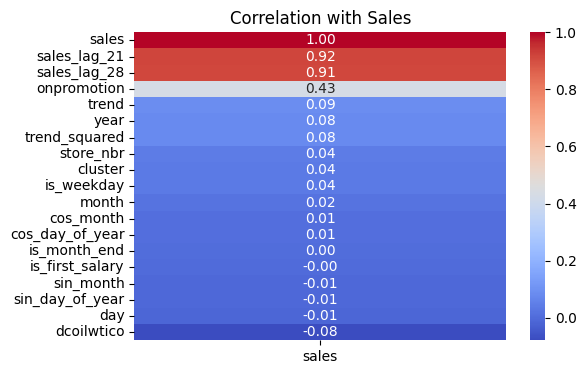

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Вычисляем корреляцию только с целевой переменной 'sales'
correlation_with_sales = X_train.corr(numeric_only=True)[['sales']].sort_values(by='sales', ascending=False)

# Создаём тепловую карту
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_with_sales, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Correlation with Sales')
plt.show()

In [9]:
X = X_train[training_start : training_end].drop('sales', axis = 1)
y = X_train[training_start : training_end]['sales']

X_validation = X_train[validation_start : ].drop('sales', axis = 1)
y_validation = X_train[validation_start : ]['sales']

# Пайплайн

In [10]:
# Предобработка данных
numerical_pipeline = Pipeline([
    ('fillna', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore', sparse=True))
])


preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),  # Для числовых признаков
    ('cat', categorical_pipeline, categorical_features)  # Для категориальных
    ], 
    remainder='passthrough'
)


# Модель 
model = xgb.XGBRegressor(
    objective="reg:tweedie",  # Используем правильное значение для Tweedie Loss
    n_estimators=987,  # Количество деревьев
    learning_rate=0.03974568823588938,  # Скорость обучения
    depth=14,  # Максимальная глубина дерева
    min_data_in_leaf=5,  # Минимальное количество данных в узле (аналог min_child_weight)
    subsample=0.7,  # Доля выборки для построения дерева
    colsample_bylevel=0.5,  # Доля признаков на уровне дерева
    reg_lambda=0.3882731379185479,  # L2-регуляризация
    reg_alpha=0.009556952677129724  # L1-регуляризация
)



# Создаем финальный пайплайн с выбранной моделью
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Обучение

In [11]:
# Обучаем модель
model_pipeline.fit(X, y)

y_pred = model_pipeline.predict(X)


print("RMSLE:",np.sqrt(mean_squared_log_error(y, y_pred)))
print("MAE:",mean_absolute_error(y, y_pred))
print("R2:",r2_score(y, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:19:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "depth", "min_data_in_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


RMSLE: 0.47574813032260616
MAE: 60.13507020460128
R2: 0.9518265728848506


# Валидация

In [12]:
y_pred_validation = model_pipeline.predict(X_validation)


print("RMSLE:",np.sqrt(mean_squared_log_error(y_validation, y_pred_validation)))
print("MAE:",mean_absolute_error(y_validation, y_pred_validation))
print("R2:",r2_score(y_validation, y_pred_validation))

RMSLE: 0.44381074894363526
MAE: 81.074192983708
R2: 0.9532151255951204


In [13]:
# Длина массива
test_size=test.shape[0]

test_data = pd.concat([train , test])

# Выборка по длине тестовых данных
ids = test_data["id"].tail(test_size)

In [14]:
# Предсказания на финальных тестовых данных
X_test_final = prepare_data(test_data)
X_test_final = X_test_final.tail(test_size)
X_test_final.drop(['sales'], axis = 1, inplace = True)


y_pred_final = model_pipeline.predict(X_test_final)  # Делаем предсказания

# Заменяем отрицательные значения на 0
y_pred_final = np.clip(y_pred_final, a_min=0, a_max=None)

# Формируем DataFrame с результатами
submission = pd.DataFrame({
    'id': ids,  # Обратите внимание на использование правильного столбца id
    'sales': y_pred_final
})

# Сохранение результатов в CSV файл
submission.to_csv('submission.csv', index=False)

In [15]:
submission

,id,sales
0,3000888,5.856771
1,3000889,0.022115
2,3000890,6.562846
3,3000891,2700.441895
4,3000892,0.082908
...,...,...
28507,3029395,326.062744
28508,3029396,90.988976
28509,3029397,1126.508057
28510,3029398,72.493568
